# Рекомендация тарифов

**Описание проекта**

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.
Построим модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверим accuracy на тестовой выборке самостоятельно.

**Шаги выполнения проекта**

1) Откроем файл с данными и изучим его. Путь к файлу: /datasets/users_behavior.csv.

2) Разделим исходные данные на обучающую, валидационную и тестовую выборки.

3) Исследуем качество разных моделей, меняя гиперпараметры. Кратко напишем выводы исследования.

4) Проверим качество модели на тестовой выборке.

5) Дополнительное задание: проверим модели на вменяемость.

6) Сделаем общий вывод.

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

сalls — количество звонков,

minutes — суммарная длительность звонков в минутах,

messages — количество sms-сообщений,

mb_used — израсходованный интернет-трафик в Мб,

is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откроем и изучим файл

In [1]:
! pip install -q phik

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import phik

In [3]:
try:
    df = pd.read_csv('users_behavior.csv') 
    print("Датасет успешно загружен")
except:
    df = pd.read_csv('/datasets/users_behavior.csv') 
    print("Датасет успешно загружен")

Датасет успешно загружен


In [4]:
# Посмотрим часть загруженных данных
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
# Посмотрим информацию по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
# Посмотрим информацию по датасету
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [7]:
# Изменим тип столбца messages на int
df['messages'] = df['messages'].astype("int")

In [8]:
# Проверим наличие дубликатов
df.duplicated().sum()

0

In [9]:
# Проверим наличие пропусков
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [10]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Видим, что выборка перешедших на тариф "Ультра" не сбалансирована - дисбаланс в 2.26 раза

In [11]:
# Посмотрим корреляцию между параметрами датасета
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Так как признак is_ultra по своей сути бинарный, то для него лучше подойдет корреляцис Спирмена.

Существуют разные коэффициенты корреляции, и не все из них универсальны. Например, корреляция Пирсона не подходит для категориальных признаков. Есть и более гибкие инструменты: так, коэффициент корреляции Фи находит взаимосвязь между категориальными, порядковыми и интервальными признаками. Чем ближе его значение по модулю к 1, тем сильнее связь. Используем этот передовой метод определения корреляции.

In [12]:
df.phik_matrix() 

interval columns not set, guessing: ['calls', 'minutes', 'messages', 'mb_used', 'is_ultra']


,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.974802,0.338665,0.521018,0.474416
minutes,0.974802,1.000000,0.333215,0.509414,0.456533
messages,0.338665,0.333215,1.000000,0.333689,0.373726
mb_used,0.521018,0.509414,0.333689,1.000000,0.493928
is_ultra,0.474416,0.456533,0.373726,0.493928,1.000000


Построим матрицу рассеяния, но избавимся от текстового представления python-объектов типа <AxesSubplot:xlabel='real_age'>
или Text(0.5, 1, 'Матрица рассеяния параметров датасета'). Это можно сделать достаточно просто, если добавить точку с запятой после последней команды в ячейке.    

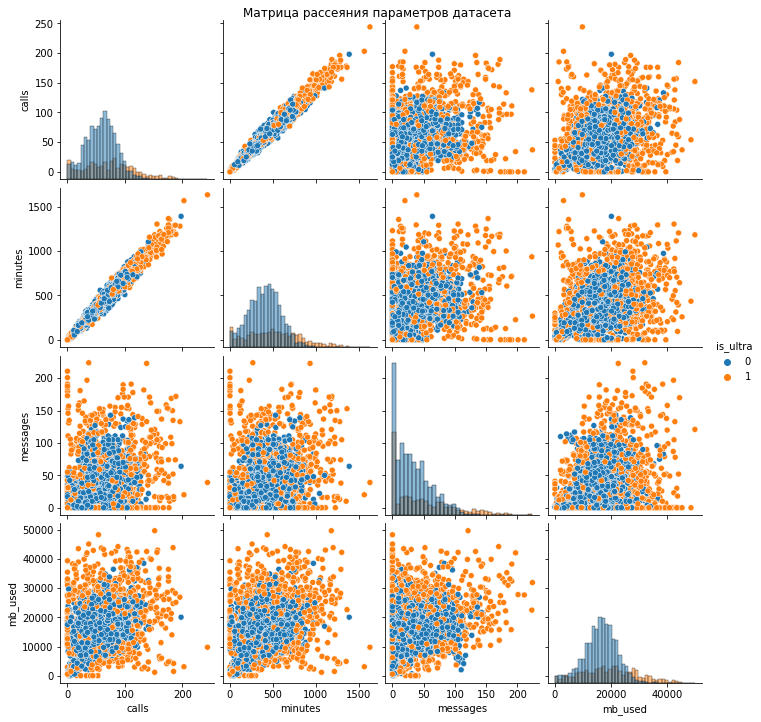

In [13]:
graph = sns.pairplot(df, hue='is_ultra', diag_kind="hist")
graph.fig.suptitle("Матрица рассеяния параметров датасета", y=1);

**Вывод**

- Пропущенных значений и дубликатов нет. 
- Типы столбцов в порядке. Можно сразу без дополнительной предоработки приступать к их анализу. 
- Очевидна линейная зависимость между звонками и минутами, чем больше звонков - тем больше минут. 

## Разобьём данные на выборки

Нам необходимо разбить данные на 3 выборки - обучающую, валидационную и тестовую.

Сначала возьмем от датасета 60% наблюдений - это будет обучающая выборка. Оставщиеся 40% поделим пополам - на тестовую и валидационную выборки. Получим разбивку данных в соотношении 60/20/20.

In [14]:
# Разобъем выборки на train(60%) и тест(40%)
df_train, df_test = train_test_split(df, test_size=0.4, random_state=777, stratify=df['is_ultra'])
features = df_test.drop('is_ultra', axis=1)
target = df_test['is_ultra']

In [15]:
# Разобъем выборки на val(20%) и test(20%)
features_valid, features_test, target_valid, target_test = train_test_split(
    features, target, test_size=0.5, random_state=777, stratify=target
)
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

Обучающая выборка:

In [16]:
features_train.shape

(1928, 4)

In [17]:
target_train.shape

(1928,)

Валидационная выборка:

In [18]:
features_valid.shape

(643, 4)

In [19]:
target_valid.shape

(643,)

Тестовая выборка:

In [20]:
features_test.shape

(643, 4)

In [21]:
target_test.shape

(643,)

**Итог:**
- данные разбили на 3 части в соотношении 60/20/20
- дисбалланс в данных оставили

## Исследуем модели

Так как у нас есть обучающий набор данных и целевой признак, который нужно предсказать по остальным признакам (тариф («Смарт» или «Ультра»)), то наша задача - это задача «Обучение с учителем». Используем задачу классификации.

Для решения задач классификации есть три метода:

- логистическая регрессия
- решающее дерево
- случайный лес

Посмотрим какая модель покажет себя лучше остальных.

### Логистическая регрессия (LogisticRegression)

In [22]:
# Так как датасет маленький, выбираем solver='liblinear'
model_logistic = LogisticRegression(solver='liblinear', random_state=777)
model_logistic.fit(features_train, target_train)
result_logistic = model_logistic.score(features_valid, target_valid)

print('Качество:', result_logistic)

Качество: 0.6982892690513219


### Решающее дерево (DecisionTreeClassifier)

In [23]:
best_accuracy = 0
best_depth = 0
for depth in range(1,15):
    model = DecisionTreeClassifier(max_depth=depth, random_state=777)
    model.fit(features_train, target_train)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth
        
print("Глубина дерева:", best_depth)
print("Качество:", best_accuracy)

Глубина дерева: 9
Качество: 0.7869362363919129


### Случайный лес (RandomForestClassifier)

In [24]:
best_accuracy = 0
best_depth = 0
for depth in range(1,10):
    for est in range(5,45,5):
        for sample in range(2,5):
            model = RandomForestClassifier(max_depth=depth, n_estimators=est, min_samples_leaf=sample, random_state=777)
            model.fit(features_train, target_train)
            accuracy = model.score(features_valid, target_valid)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_depth = depth
                best_est = est
                best_sample = sample
                
print("Глубина дерева:", best_depth)
print("Количество деревьев:", best_est)
print("Минимум объектов в узле:", best_sample)
print("Качество:", best_accuracy)

Глубина дерева: 8
Количество деревьев: 40
Минимум объектов в узле: 2
Качество: 0.8118195956454122


**Вывод**
Обучая три разные модели были полученны лучшие метрики качества для каждой из них. Лучшее качество 0.8118195956454122 показала модель Случайный лес. Обучается модель дольше остальных, но так как у нас датасет небольшой, то это для нас не критично. Второе место по качеству заняла модель Решающее дерево - 0.7869362363919129. И худшее качество показала модель Логистическая регрессия - 0.6982892690513219. Лишь две модели из трех прошли минимальный требуемый порог в 0,75 на тренировочных данных.

## Проверим модель на тестовой выборке

Проверим лучшую выбранную модель на тестовой выборке

In [25]:
# Случайный лес
best_accuracy_rf = 0
best_depth = 0
for depth in range(1,10):
    for est in range(5,45,5):
        for sample in range(2,5):
            model = RandomForestClassifier(max_depth=depth, n_estimators=est, min_samples_leaf=sample, random_state=777)
            model.fit(features_train, target_train)
            accuracy = model.score(features_test, target_test)
            if accuracy > best_accuracy_rf:
                best_accuracy_rf = accuracy
                best_depth = depth
                best_est = est
                best_sample = sample

print("Качество:", best_accuracy_rf)
print("Максимальная глубина дерева:", best_depth)
print("Количество деревьев в лесу:", best_est)
print("Минимальное количество выборок, необходимых для конечного узла:", best_sample)

Качество: 0.8211508553654744
Максимальная глубина дерева: 9
Количество деревьев в лесу: 5
Минимальное количество выборок, необходимых для конечного узла: 2


**Вывод**

На тестовой выборке Случайный лес показал себя немного лучше, чем на тренировочной - качество: 0.8211508553654744, а на тренировочной было 0.8118195956454122. Однако так или иначе мы превысили по качеству требуемый порог в 0,75.

## (бонус) Проверим модели на адекватность

Для проверки наших 3-х моделей сравним их со стандартной готовым классификатором для обучения DummyClassifier. Эта простейшая модель которую можно построить в начале работы, она предсказывает наиболее часто встречающийся класс. Так мы получим контрольные данные для сравнительной оценки построенной нами более сложной модели. Используем три разные стратегии генерации прогнозов:

1) “most_frequent”: predict метод всегда возвращает наиболее часто используемую метку класса в наблюдаемом параметре y аргумент, переданный в fit. Метод predict_proba возвращает соответствующий вектор в кодировке one-hot.

2) “stratified”: predict_proba метод случайным образом выбирает однозначные векторы из полиномиального распределения, параметризованного эмпирическим классом априорных вероятностей. predictМетод возвращает метку класса, которая получила вероятность один в однократном векторе из predict_proba. Следовательно, каждая строка выборки обоих методов независима и распределена одинаково.

3) “uniform”: генерирует случайным образом однородные прогнозы из списка уникальных классов, наблюдаемых в y, т. е. каждый класс имеет равную вероятность.

In [26]:
best_accuracy = 0
best_depth = 0
best_startegy = None

for strategy in ['most_frequent', 'uniform', 'stratified']:
    model = DummyClassifier(strategy=strategy, random_state=777)
    model.fit(features_train, target_train)
    naive_accuracy = model.score(features_test, target_test)
    if naive_accuracy > best_accuracy:
        best_accuracy = naive_accuracy
        best_depth = depth
        best_startegy = strategy
        
print("Лучшая стратегия :", best_startegy)        
print("Качество наивного прогноза :", best_accuracy)
print("Качество нашего прогноза :", best_accuracy_rf)

Лучшая стратегия : most_frequent
Качество наивного прогноза : 0.6936236391912908
Качество нашего прогноза : 0.8211508553654744


**Вывод**

Мы видим что доля правильных ответов моделей выше, чем у нашего наивного предположения, считаем все модели адекватными. А если сравнивать лишь с выбранной моделью Случайных лес, то каждая стратегия генерации прогноза показала гораздо худший результат качества на наивном предположении, чем качество нашего прогноза, равное 0.8211508553654744. Соответственно, делаем вывод, что наша модель адекватна.

## Общий вывод

В подготовленном датасете с данными о поведении клиентов, которые уже перешли на тарифы Смарт и Ультра, наша задача состояла в том, чтобы построить модель (классификации), которая выберет подходящий тариф с максимально большим значением accuracy (больше 0.75). Данные уже были подготовлены, поэтому с ними мы ничего не делали.

В первом же пункте нашего исследования мы увидели, что присутствует дисбаланс классов. Но с ним мы ничего не делаем.

Во втором пункте нашего исследования мы разбили наш датасет на выборки:
- features_train - на которой мы обучали нашу модель
- target_train - на которой мы проверяли нашу модель (валидационная выборка)
- features_valid - целевой признак обучающей выборки (на нем мы также обучали нашу модель)
- target_valid - целевой признак валидационной выборки
- features_test - фичи тестовой модели, которые мы передавали нашей обученной модели (с уже настроенными гиперпараметрами)
- target_test - целевой признак тестовой выборки (для проверки параметра accuracy)

У нас получились данные для обучения, валидационная выборка и тестовая выборка.

В третьем и четвертом пункте мы иссоедовали модели на тренировочных и тестовых данных. Были проверены три модели: логистическая регрессия, случайный лес, деревья решений. Наилучшее качество (0.8211508553654744) достигается при использовании RandomForest (Случайный лес) с параметрками:
- Максимальная глубина дерева: 9
- Количество деревьев в лесу: 5
- Минимальное количество выборок, необходимых для конечного узла: 2

Хотя эта модель работает дольше всего, выбрали её из-за точности и благодаря тому, что датасет небольшой и время его работы для нас в данном случае не критично.

Качество модели "Решающее дерево" - наилучшее "accuracy" на валидационной выборке = 0.7869362363919129

Качество модели "Логистическая регрессия" - наилучшее "accuracy" на валидационной выборке = = 0.6982892690513219 (самое низкое качество из всех трёх моделей, хотя она и самая быстрая)

Проверка модели на адекватность в пятом пункте нашего исследования показала, что качество наивного прогноза (DummyClassifier) гораздо хуже (0.6936236391912908) даже на лучшей стратегии most_frequent, чем качество любой из наших моделей и особенно Случайного леса. Соответственно, делаем вывод, что наша модель адекватна.